In [1]:
import contextily as ctx
import folium
import geopandas as gpd
import numpy as np
import pandas as pd
import requests


In [2]:
output_maps_path = '/home/marthe/Documents/DS/bacasable_doc/'

# Préparation des données géographiques de Marseille

In [41]:
# Importation des données géographiques des quartiers de Marseille
url = 'https://www.data.gouv.fr/api/1/datasets/r/8a8f7f54-7f91-482c-a78c-dd09d893d1b6'
file = requests.get(url)
data = file.content
marseille_quartiers_data = gpd.read_file(data)
marseille_quartiers_data.head(2)

,DEPCO,NOM_CO,NOM_QUA,geometry
0,13201,Marseille 1er Arrondissemen,BELSUNCE,"MULTIPOLYGON (((5.38086 43.29924, 5.38087 43.2..."
1,13201,Marseille 1er Arrondissemen,CHAPITRE,"MULTIPOLYGON (((5.38525 43.29906, 5.38485 43.2..."


In [42]:
marseille_quartiers_map = marseille_quartiers_data.rename({'NOM_QUA' : 'Quartier'}, axis = 1)
marseille_quartiers_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Préparation des données des pav

In [44]:
# Importation des données concernant les points d'apport volontaire
url = 'https://www.data.gouv.fr/api/1/datasets/r/e46c6879-49e7-4727-8f3b-62df90ac5a5a'
gouv_data = pd.read_csv(url, sep = ';')

In [45]:
gouv_data.head(2)

,OBJECTID,Ex identifiant CT,Date création mobilier,Famille Osis,Type de colonne,Modèle,Volume intérieur m3,longitude,latitude,Date de mise à jour de la donnée,...,Code postal,Quartier,Accessibilité,Nom de colonne,Abréviation type de flux,Trigramme de la commune,Propriétaire,created_date,last_edited_date,geo_point_2d
0,125490,PAV07076,2022-12-31T01:00:00+00:00,Equipement Mobilier Urbain,Aérien,COMPOECO,3.0,5.361002,43.280296,2026-01-22T13:58:59+00:00,...,13007.0,BOMPARD,NaN,NaN,NaN,MRS7,Propriétaire Privé,2025-12-22T15:36:07+00:00,2024-02-02T11:13:06+00:00,"43.28029575458368, 5.361001581597926"
1,125491,ENT07035,2022-12-31T01:00:00+00:00,Equipement Mobilier Urbain,Enterré,CITEC T5,3.0,5.366096,43.270026,2026-01-22T11:49:15+00:00,...,13007.0,LE ROUCAS BLANC,NaN,NaN,NaN,MRS7,NaN,2025-12-22T15:36:07+00:00,2024-02-02T11:13:06+00:00,"43.27002588878141, 5.366096461663119"


In [48]:
# Extraction des variables d'intérêt
pav_data = gouv_data[['OBJECTID', 'Code Commune INSEE', 'Quartier', 'Volume intérieur m3', 'longitude', 'latitude']]


In [49]:
# Extraction des observations concernant les quartiers de Marseille
pav_marseille = pav_data.loc[(pav_data['Code Commune INSEE'] > 13200) & (pav_data['Code Commune INSEE'] < 13217)]
pav_marseille = pav_marseille.dropna(axis = 0, subset = ['Quartier'])
pav_marseille.head()


,OBJECTID,Code Commune INSEE,Quartier,Volume intérieur m3,longitude,latitude
0,125490,13207.0,BOMPARD,3.0,5.361002,43.280296
1,125491,13207.0,LE ROUCAS BLANC,3.0,5.366096,43.270026
2,125502,13209.0,STE MARGUERITE,3.0,5.412423,43.273180
3,125504,13209.0,LE CABOT,3.0,5.417667,43.261696
4,125505,13213.0,SAINT JEROME,4.0,5.420109,43.338754


In [50]:
# Uniformisation des noms de quartiers 
# Attention : certains quartiers de la carte ne sont pas référencés dans les données de points d'apport

marseille_quartiers_map['Quartier'] = marseille_quartiers_map['Quartier'].replace(
    {
        'SAINT MAURON' : 'SAINT MAURONT',
        'VIELLE CHAPELLE' : 'VIEILLE CHAPELLE'
    }
)

pav_marseille['Quartier'] = pav_marseille['Quartier'].replace(
    {
    'CHATEAU GOMBERT' : 'CHATEAU-GOMBERT',
    'LA POINTE ROUGE' : 'POINTE ROUGE',
    'LA VILLETTE' : 'LA VILETTE',
    'LE ROUCAS' : 'ROUCAS BLANC',
    'LE ROUCAS BLANC' : 'ROUCAS BLANC',
    'LES CHUTES LAVIES' : 'CHUTES LAVIE',
    'LES CINQ AVENUES' : 'CINQ AVENUES',
    'LES GRANDS CARMES' : 'GRANDS CARMES',
    'ST BARNANE' : 'SAINT BARNABE',
    'STE MARGUERITE' : 'SAINTE MARGUERITE'
}
)




In [51]:
# conversion en geodataframe
gdf_pav_marseille = gpd.GeoDataFrame(
    pav_marseille,
    geometry=gpd.points_from_xy(
        pav_marseille['longitude'],
        pav_marseille['latitude'],
        crs="EPSG:4326"))

gdf_pav_marseille = gdf_pav_marseille.to_crs(2154)

In [52]:
zone_couverte = gdf_pav_marseille.copy()
zone_couverte['Volume intérieur m3'] = zone_couverte['Volume intérieur m3'].replace({2000.0 : 2.0, 3000.0 : 3.0})
zone_couverte['Volume intérieur m3'] = zone_couverte['Volume intérieur m3'].fillna(1.0)
zone_couverte['Volume intérieur m3'].unique()

array([3. , 4. , 2. , 1. , 5. , 3.2, 2.2, 1.8])

In [54]:
# Ajout des surfaces couvertes
zone_couverte['geometry'] = zone_couverte['geometry'].buffer(150)
zone_couverte.head(2)


,OBJECTID,Code Commune INSEE,Quartier,Volume intérieur m3,longitude,latitude,geometry
0,125490,13207.0,BOMPARD,3.0,5.361002,43.280296,"POLYGON ((892029.815 6245220.669, 892029.815 6..."
1,125491,13207.0,ROUCAS BLANC,3.0,5.366096,43.270026,"POLYGON ((892477.636 6244091.897, 892477.636 6..."


In [56]:
marseille_quartiers_map = marseille_quartiers_map.to_crs(3857)
zone_couverte = zone_couverte.to_crs(3857)
gdf_pav_marseille = gdf_pav_marseille.to_crs(3857)

In [ ]:
# regroupement de l'ensemble des zones de couverture en une seule zone couverte
# pour éviter la superposition de zones couvertes par plusieurs pav sur la carte finale
zone_couverte = zone_couverte.dissolve().reset_index()

In [61]:
# séparation de la zone couverte par quartier
marseille_couverture = marseille_quartiers_map.copy()
marseille_couverture['geometry'] = marseille_couverture['geometry'].apply(lambda x : x.intersection(zone_couverte['geometry'][0]))

# Calcul du taux de couverture par quartier
marseille_couverture['taux_couverture'] = marseille_couverture['geometry'].area/marseille_quartiers_map['geometry'].area*100
marseille_couverture['taux_couverture'] = marseille_couverture['taux_couverture'].astype(int)


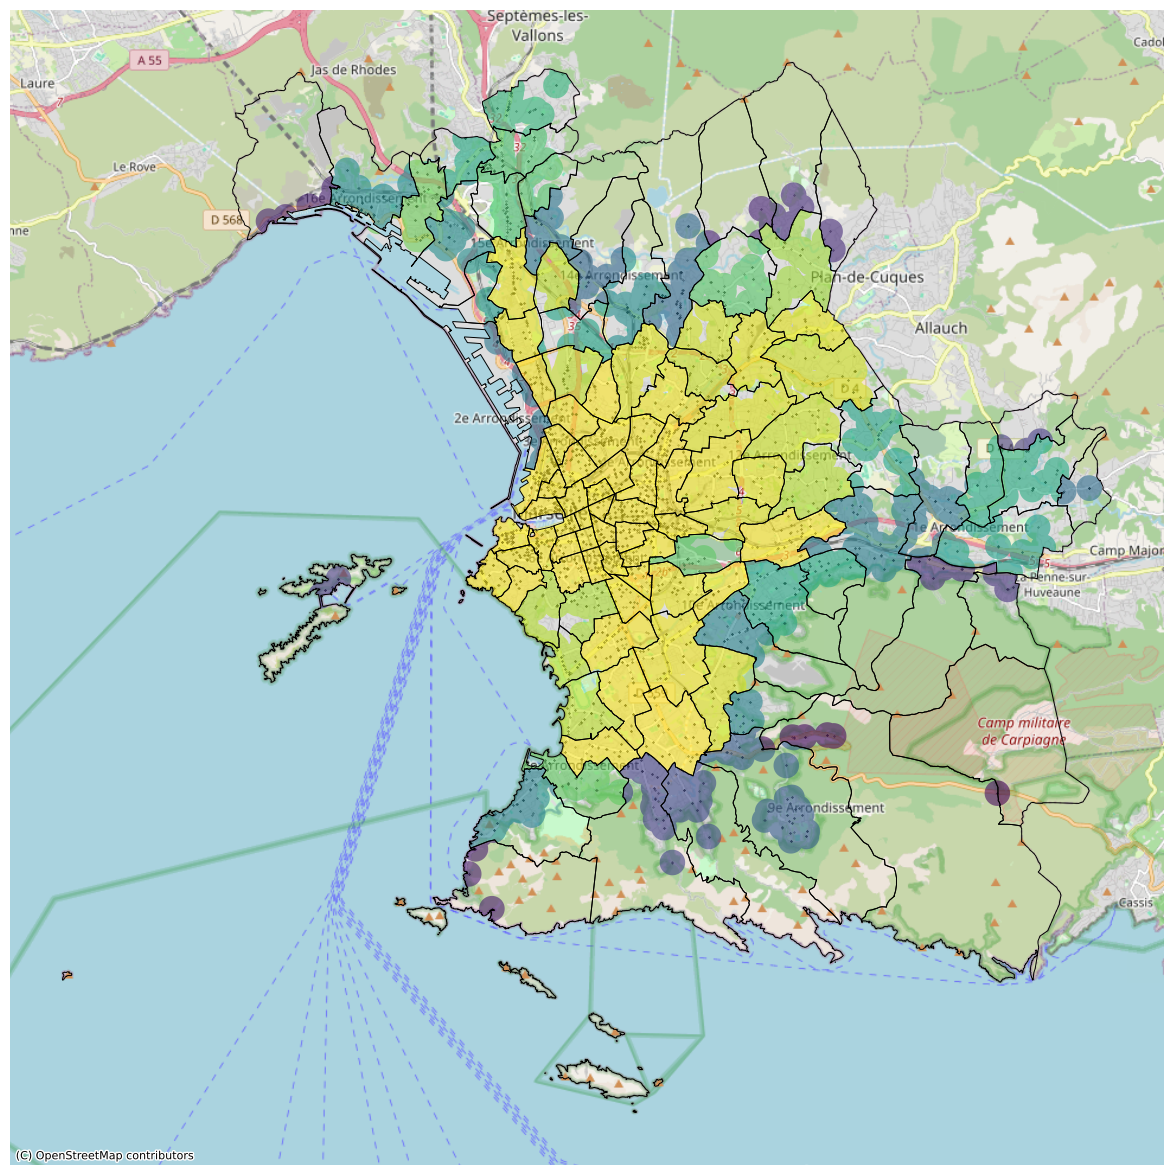

In [69]:
base = marseille_quartiers_map.boundary.plot(edgecolor = 'black', linewidth = 0.7, figsize = (15,15))


gdf_pav_marseille.plot(
    ax = base,
    color = 'Black',
    markersize = 0.1
    )

marseille_couverture.plot(
    ax = base,
    column = 'taux_couverture',
    alpha = 0.6
    )


ctx.add_basemap(ax = base, source = ctx.providers.OpenStreetMap.Mapnik)

base.set_axis_off()


In [76]:
map = folium.Map(
    location = [43.3, 5.4],
    tiles = 'cartodbpositron',
    zoom_start = 12,
    max_zoom=17,
    control_scale=True
    )


gdf_pav_marseille.explore(
    m = map,
    tooltip = ['Volume intérieur m3'],
    marker_kwds=dict(radius=0.5, fill=True),
    color = 'Black'
    )



marseille_couverture.explore(
    m = map,
    column = 'taux_couverture',
    cmap = 'RdBu',
    tooltip = ['Quartier', 'taux_couverture'],
    popup = True,
    style_kwds =dict(fillOpacity = 0.8),
    legend = True
    )

marseille_quartiers_map.boundary.explore(
    m = map,
    color = 'Black'
)

map_title = "couverture des pav (rayon 150 m)"
title_html = f'<h1 style="position:absolute;z-index:100000;left:40vw" >{map_title}</h1>'
map.get_root().html.add_child(folium.Element(title_html))


map.save(output_maps_path + 'couverture_quartier.html')


